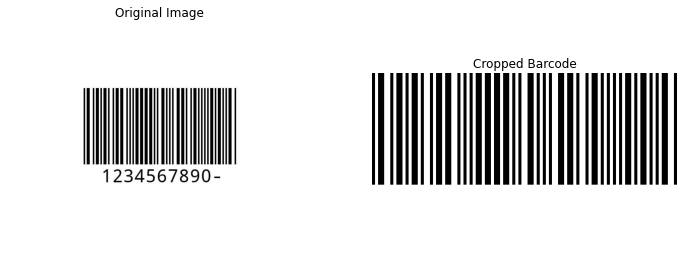

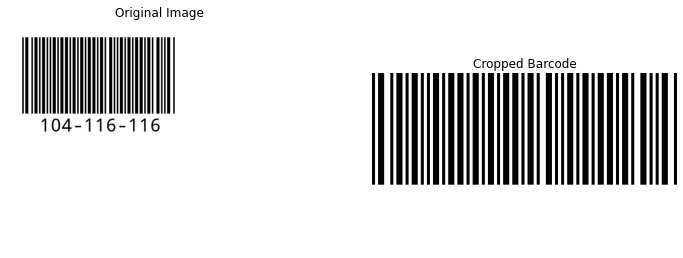

AttributeError: 'str' object has no attribute 'shape'

In [ ]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt

def clean(img, margin=20):
    # Convert to grayscale if the image is in color
    if len(img.shape) == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Threshold the image to detect barcode regions
    _, thresholded = cv.threshold(img, 128, 255, cv.THRESH_BINARY_INV)
    contours, _ = cv.findContours(thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img  # Return the original image if no contours are found

    # Find the bounding box for the barcode
    x_min = min(cv.boundingRect(c)[0] for c in contours)
    x_max = max(cv.boundingRect(c)[0] + cv.boundingRect(c)[2] for c in contours)
    _, y, _, h = cv.boundingRect(max(contours, key=cv.contourArea))

    # Crop the barcode region
    cropped_img = img[y:y + h, x_min:x_max]

    # Remove numbers or text from the bottom margin
    cropped_img[-margin:, :] = 255  # Set the bottom margin to white

    return cropped_img

def preprocess_image(image_path, special_image=False, remove_hand_image=False):
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    if img is None:
        return None

    if remove_hand_image:
       img = remove_hand(image_path)
    elif special_image:
        img = cv.resize(cv.filter2D(img, -1, np.ones((7, 1), np.float32) / 5), (img.shape[1] * 4, img.shape[0] * 4))
        _, img = cv.threshold(img, 128, 255, cv.THRESH_BINARY)
    else:
        img = cv.adaptiveThreshold(cv.normalize(cv.GaussianBlur(img, (5, 5), 0), None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX), 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 15, 8)

    img = cv.dilate(img, cv.getStructuringElement(cv.MORPH_RECT, (1, 12)), iterations=3)
    return cv.morphologyEx(img, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_RECT, (3, 3)), iterations=1)


def remove_hand(image_path):
        img = cv.imread(image_path)
        hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

        # Define a more comprehensive skin color range
        lower_skin1 = np.array([0, 20, 50], dtype=np.uint8)
        upper_skin1 = np.array([25, 170, 255], dtype=np.uint8)
        lower_skin2 = np.array([160, 20, 50], dtype=np.uint8)
        upper_skin2 = np.array([180, 170, 255], dtype=np.uint8)

        # Create two masks to cover the skin color range
        mask1 = cv.inRange(hsv, lower_skin1, upper_skin1)
        mask2 = cv.inRange(hsv, lower_skin2, upper_skin2)
        skin_mask = cv.bitwise_or(mask1, mask2)

        # Morphological operations to remove noise and close gaps
        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
        skin_mask = cv.morphologyEx(skin_mask, cv.MORPH_CLOSE, kernel, iterations=2)
        skin_mask = cv.morphologyEx(skin_mask, cv.MORPH_OPEN, kernel, iterations=2)

        # Find contours in the skin mask
        contours, _ = cv.findContours(skin_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        if not contours:
            return None

        # Assume the largest contour is the hand
        largest_contour = max(contours, key=cv.contourArea)

        # Create a mask for the hand
        hand_mask = np.zeros_like(skin_mask)
        cv.drawContours(hand_mask, [largest_contour], -1, 255, thickness=cv.FILLED)

        # Invert the hand mask to prepare for inpainting
        hand_mask_inv = cv.bitwise_not(hand_mask)

        # Inpaint the original image using the inverted mask
        img_no_hand = cv.inpaint(img, hand_mask, inpaintRadius=3, flags=cv.INPAINT_TELEA)

        # Repair barcode area
        gray = cv.cvtColor(img_no_hand, cv.COLOR_BGR2GRAY)
        erosion_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 80))
        binary_erode = cv.erode(gray, erosion_kernel, iterations=1)
        dialation_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 80))
        binary_opened = cv.dilate(binary_erode, dialation_kernel, iterations=1)
        dilationkernel2 = cv.getStructuringElement(cv.MORPH_RECT, (1, 11))
        binary_final = cv.dilate(binary_opened, dilationkernel2, iterations=1)

        kernel = np.ones((40, 1), np.float32) / 40
        vertical_mean_filtered = cv.filter2D(binary_final, -1, kernel)
        img = cv.normalize(vertical_mean_filtered, None, 0, 255, cv.NORM_MINMAX)
        return img 

def process_test_cases(image_folder, special_image_index , remove_hand_index):
    """
    Processes test cases, applying specific preprocessing based on the image index.
    """
    files = [f for f in os.listdir(image_folder) if f.endswith(".jpg")]
    files.sort(key=lambda x: int(x.split(' ')[0]))
    output_folder = os.path.join(image_folder, "Processed_Output")
    os.makedirs(output_folder, exist_ok=True)

    for i, file_name in enumerate(files):
        image_path = os.path.join(image_folder, file_name)
        original_img = cv.imread(image_path)
        cleaned_img = preprocess_image(image_path, special_image=(i + 1 == special_image_index),
                                       remove_hand_image=(i + 1 == remove_hand_index))
        if cleaned_img is not None:
            cropped_img = clean(cleaned_img)
            cv.imwrite(os.path.join(output_folder, f"Cropped_{file_name}"), cropped_img)
            display_before_after(original_img, cropped_img)

def display_before_after(original_img, cropped_img, title_before="Original Image", title_after="Cropped Barcode"):
    """
    Displays the original and processed images side by side for comparison.
    """
    plt.figure(figsize=(12, 6))
    for i, (img, title) in enumerate([(original_img, title_before), (cropped_img, title_after)]):
        plt.subplot(1, 2, i + 1)
        plt.imshow(img if len(img.shape) == 2 else cv.cvtColor(img, cv.COLOR_BGR2RGB), cmap='gray' if len(img.shape) == 2 else None)
        plt.title(title)
        plt.axis('off')
    plt.show()

if __name__ == "__main__":
    folder = "/Users/mohamedwalid/Desktop/Semester 7/Computer vision/CV-main/Test Cases-20241123"
    process_test_cases(folder, special_image_index=7, remove_hand_index=3)


# respective trandformations for each image: